In [15]:
import os, sys, subprocess

def get_gpu_name():
    try:
        out_str = subprocess.run(["nvidia-smi", "--query-gpu=gpu_name", "--format=csv"], stdout=subprocess.PIPE).stdout
        out_list = out_str.decode("utf-8").split('\n')
        out_list = out_list[1:-1]
        return out_list
    except Exception as e:
        print(e)

def get_cuda_version():
    """Get CUDA version"""
    if sys.platform == 'win32':
        raise NotImplementedError("Implement this!")
        # This breaks on linux:
        #cuda=!ls "C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA"
        #path = "C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\" + str(cuda[0]) +"\\version.txt"
    elif sys.platform == 'linux' or sys.platform == 'darwin':
        path = '/usr/local/cuda/version.txt'
    else:
        raise ValueError("Not in Windows, Linux or Mac")
    if os.path.isfile(path):
        with open(path, 'r') as f:
            data = f.read().replace('\n','')
        return data
    else:
        return "No CUDA in this machine"
    
print(get_gpu_name())
print(get_cuda_version())

['Tesla K80', 'Tesla K80']
CUDA Version 9.0.176


In [16]:
import os
import sys
import time
import math
import keras
import datetime
import itertools
import numpy as np
import pandas as pd

from keras.layers import * 
from keras.models import Model
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler

In [17]:
# Append TSPerf path to sys.path
nb_dir = os.path.split(os.getcwd())[0]
tsperf_dir = os.path.dirname(os.path.dirname(os.path.dirname(nb_dir)))
if tsperf_dir not in sys.path:
    sys.path.append(tsperf_dir)

from common.metrics import MAPE
import retail_sales.OrangeJuice_Pt_3Weeks_Weekly.common.benchmark_settings as bs

In [18]:
# Data paths
DATA_DIR = '../../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Data parameters
MAX_STORE_ID = 137
MAX_BRAND_ID = 11

# Parameters of the model
PRED_HORIZON = 3
PRED_STEPS = 2
SEQ_LEN = 64 #8
DYNAMIC_FEATURES = ['profit', 'feat'] #['deal', 'feat']
STATIC_FEATURES = ['store', 'brand']

In [19]:
def df_from_cartesian_product(dict_in):
    """Generate a Pandas dataframe from Cartesian product of lists.
    
    Args: 
        dict_in (Dictionary): Dictionary containing multiple lists
        
    Returns:
        df (Dataframe): Dataframe corresponding to the Caresian product of the lists
    """
    from collections import OrderedDict
    from itertools import product
    od = OrderedDict(sorted(dict_in.items()))
    cart = list(product(*od.values()))
    df = pd.DataFrame(cart, columns=od.keys())
    return df

def gen_sequence(df, seq_len, seq_cols, start_timestep=0, end_timestep=None):
    """Reshape features into an array of dimension (time steps, features).  
    
    Args:
        df (Dataframe): Time series data of a specific (store, brand) combination
        seq_len (Integer): The number of previous time series values to use as input features
        seq_cols (List): A list of names of the feature columns 
        start_timestep (Integer): First time step you can use to create feature sequences
        end_timestep (Integer): Last time step you can use to create feature sequences
        
    Returns:
        A generator object for iterating all the feature sequences
    """
    data_array = df[seq_cols].values
    if end_timestep is None:
        end_timestep = df.shape[0]
    for start, stop in zip(range(start_timestep, end_timestep-seq_len+2), range(start_timestep+seq_len, end_timestep+2)):
        yield data_array[start:stop, :]

def gen_sequence_array(df_all, seq_len, seq_cols, start_timestep=0, end_timestep=None):
    """Combine feature sequences for all the combinations of (store, brand) into an 3d array.
    
    Args:
        df_all (Dataframe): Time series data of all stores and brands
        seq_len (Integer): The number of previous time series values to use as input features
        seq_cols (List): A list of names of the feature columns 
        start_timestep (Integer): First time step you can use to create feature sequences
        end_timestep (Integer): Last time step you can use to create feature sequences
        
    Returns:
        seq_array (Numpy Array): An array of the feature sequences of all stores and brands    
    """
    seq_gen = (list(gen_sequence(df_all[(df_all['store']==cur_store) & (df_all['brand']==cur_brand)], \
                                 seq_len, seq_cols, start_timestep, end_timestep)) \
              for cur_store, cur_brand in itertools.product(df_all['store'].unique(), df_all['brand'].unique()))
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    return seq_array

def static_feature_array(df_all, total_timesteps, seq_cols):
    """Generate an arary which encodes all the static features.
    
    Args:
        df_all (Dataframe): Time series data of all stores and brands
        total_timesteps (Integer): Total number of training samples for each store and brand
        seq_cols (List): A list of names of the static feature columns (e.g., store index)
        
    Return:
        fea_array (Numpy Array): An array of static features of all stores and brands
    """
    fea_df = data_filled.groupby(['store', 'brand']). \
                         apply(lambda x: x.iloc[:total_timesteps,:]). \
                         reset_index(drop=True)
    fea_array = fea_df[seq_cols].values
    return fea_array

def normalize_dataframe(df, seq_cols, scaler=MinMaxScaler()):
    """Normalize a subset of columns of a dataframe.
    
    Args:
        df (Dataframe): Input dataframe 
        seq_cols (List): A list of names of columns to be normalized
        scaler (Scaler): A scikit learn scaler object
    
    Returns:
        df_scaled (Dataframe): Normalized dataframe
    """
    cols_fixed = df.columns.difference(seq_cols)
    df_scaled = pd.DataFrame(scaler.fit_transform(df[seq_cols]), 
                            columns=seq_cols, index=df.index)
    df_scaled = pd.concat([df[cols_fixed], df_scaled], axis=1)
    return df_scaled, scaler

In [20]:
r = 1
print('---- Round ' + str(r+1) + ' ----')
# Load training data
train_df = pd.read_csv(os.path.join(TRAIN_DIR, 'train_round_'+str(r+1)+'.csv'))
train_df['move'] = train_df['logmove'].apply(lambda x: round(math.exp(x)))
train_df.drop('logmove', axis=1, inplace=True)
print(train_df.head(3))
print('')
# Fill missing values
store_list = train_df['store'].unique()
brand_list = train_df['brand'].unique()
week_list = range(bs.TRAIN_START_WEEK, bs.TEST_END_WEEK_LIST[r]+1)
d = {'store': store_list,
     'brand': brand_list,
     'week': week_list}        
data_grid = df_from_cartesian_product(d)
data_filled = pd.merge(data_grid, train_df, how='left', 
                        on=['store', 'brand', 'week'])
print('Number of missing rows is {}'.format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
print('')
data_filled = data_filled.groupby(['store', 'brand']). \
                          apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
print(data_filled.head(3))
print('')

---- Round 2 ----
   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6215

   brand  store  week  constant    price1    price2    price3    price4  \
0      1      2    40       1.0  0.060469  0.060497  0.042031  0.029531   
1      1      2    41       1.0  0.060469  0.060497  0.042031  0.

In [21]:
# Normalize the dataframe of features
cols_normalize = data_filled.columns.difference(['store','brand','week'])
data_scaled, min_max_scaler = normalize_dataframe(data_filled, cols_normalize)
data_scaled.head()

,brand,store,week,constant,deal,feat,move,price1,price10,price11,price2,price3,price4,price5,price6,price7,price8,price9,profit
0,1,2,40,0.0,1.0,0.0,0.011436,1.0,0.493088,1.0,0.993939,0.686433,0.434783,1.0,1.0,0.731481,0.977528,0.485356,0.38567
1,1,2,41,0.0,1.0,0.0,0.011436,1.0,0.493088,1.0,0.993939,0.686433,0.434783,1.0,1.0,0.731481,0.977528,0.485356,0.38567
2,1,2,42,0.0,1.0,0.0,0.011436,1.0,0.493088,1.0,0.993939,0.686433,0.434783,1.0,1.0,0.731481,0.977528,0.485356,0.38567
3,1,2,43,0.0,1.0,0.0,0.011436,1.0,0.493088,1.0,0.993939,0.686433,0.434783,1.0,1.0,0.731481,0.977528,0.485356,0.38567
4,1,2,44,0.0,1.0,0.0,0.011436,1.0,0.493088,1.0,0.993939,0.686433,0.434783,1.0,1.0,0.731481,0.977528,0.485356,0.38567


In [22]:
# Create sequence array for 'move'
start_timestep = 0
end_timestep = bs.TRAIN_END_WEEK_LIST[r]-bs.TRAIN_START_WEEK-PRED_HORIZON
train_input1 = gen_sequence_array(data_scaled, SEQ_LEN, ['move'], start_timestep, end_timestep)
train_input1.shape

(29216, 64, 1)

In [23]:
# Create sequence array for other dynamic features
start_timestep = PRED_HORIZON
end_timestep = bs.TRAIN_END_WEEK_LIST[r]-bs.TRAIN_START_WEEK
train_input2 = gen_sequence_array(data_scaled, SEQ_LEN, DYNAMIC_FEATURES, start_timestep, end_timestep)
train_input2.shape

(29216, 64, 2)

In [24]:
seq_in = np.concatenate((train_input1, train_input2), axis=2)
seq_in.shape

(29216, 64, 3)

In [25]:
# Create array of static features
total_timesteps = bs.TRAIN_END_WEEK_LIST[r]-bs.TRAIN_START_WEEK-SEQ_LEN-PRED_HORIZON+2
cat_fea_in = static_feature_array(data_filled, total_timesteps, ['store', 'brand'])
cat_fea_in.shape

(29216, 2)

In [26]:
# Create training output
start_timestep = SEQ_LEN+1
end_timestep = bs.TRAIN_END_WEEK_LIST[r]-bs.TRAIN_START_WEEK
train_output = gen_sequence_array(data_filled, PRED_STEPS, ['move'], start_timestep, end_timestep)
train_output = np.squeeze(train_output)
train_output.shape

(29216, 2)

In [27]:
# Model definition
def create_dcnn_model(seq_len, kernel_size=2, n_filters=2, n_input_series=1, n_outputs=1):
    # Sequential input
    seq_in = Input(shape=(seq_len, n_input_series))
    # Categorical input
    cat_fea_in = Input(shape=(2,), dtype='uint8')
    store_id = Lambda(lambda x: x[:, 0, None])(cat_fea_in)
    brand_id = Lambda(lambda x: x[:, 1, None])(cat_fea_in)
    store_embed = Embedding(MAX_STORE_ID+1, 7, input_length=1)(store_id)
    brand_embed = Embedding(MAX_BRAND_ID+1, 4, input_length=1)(brand_id)
    
    # Dilated convolutional layers
    c1 = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=1, 
                padding='causal', activation='relu')(seq_in)
    c2 = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=2, 
                padding='causal', activation='relu')(c1)
    c3 = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=4, 
                padding='causal', activation='relu')(c2)
    # Skip connections
    c4 = concatenate([c1, c3])
    # Output of convolutional layers 
    conv_out = Conv1D(8, 1, activation='relu')(c4)
    conv_out = Dropout(0.25)(conv_out)
    conv_out = Flatten()(conv_out)
    
    # Concatenate with categorical features
    x = concatenate([conv_out, Flatten()(store_embed), Flatten()(brand_embed)])
    #x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(n_outputs, activation='linear')(x)
    
    model = Model(inputs=[seq_in, cat_fea_in], outputs=output)
    adam = optimizers.Adam(lr=0.01)
    model.compile(loss='mse', optimizer=adam, metrics=['mae'])
    return model

In [28]:
model = create_dcnn_model(seq_len=SEQ_LEN, n_input_series=3, n_outputs=PRED_STEPS)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 3)        0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 64, 2)        14          input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 64, 2)        10          conv1d_5[0][0]                   
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 64, 2)        10          conv1d_6[0][0]                   
__________________________________________________________________________________________________
concatenat

In [29]:
#model.fit([seq_in, cat_fea_in], train_output, epochs=2, batch_size=2, validation_data=([seq_in, cat_fea_in], train_output))

In [30]:
from keras.utils import multi_gpu_model

try:
    model = multi_gpu_model(model)
    print("Training using multiple GPUs..")
except:
    print("Training using single GPU or CPU..")

Training using multiple GPUs..


In [31]:
%%time
adam = optimizers.Adam(lr=0.01)
#model.compile(loss='mse', optimizer=adam, metrics=['mae'])
model.compile(loss='mean_absolute_percentage_error', optimizer=adam, metrics=['mean_absolute_percentage_error'])
#model.fit([seq_in, cat_fea_in], train_output, epochs=2, batch_size=2, validation_data=([seq_in, cat_fea_in], train_output))
model.fit([seq_in, cat_fea_in], train_output, epochs=1, batch_size=2, validation_split=0.1)

Train on 26294 samples, validate on 2922 samples
Epoch 1/1
26294/26294 [==============================] - 130s 5ms/step - loss: 48.7748 - mean_absolute_percentage_error: 48.7748 - val_loss: 57.2644 - val_mean_absolute_percentage_error: 57.2644
CPU times: user 5min 12s, sys: 1min 29s, total: 6min 41s
Wall time: 2min 11s


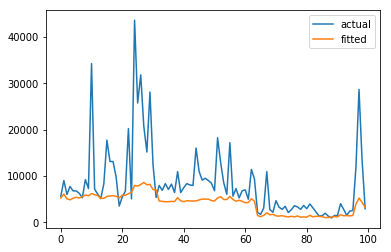

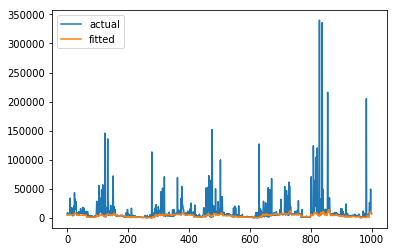

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 100
pred_sample = model.predict([seq_in[:n,:], cat_fea_in[:n,:]])[:,0]
plt.figure()
plt.plot(train_output[:n,0])
plt.plot(pred_sample)
plt.legend(['actual', 'fitted'])
plt.show()

n = 1000
pred_sample = model.predict([seq_in[:n,:], cat_fea_in[:n,:]])[:,0]
plt.figure()
plt.plot(train_output[:n,0])
plt.plot(pred_sample)
plt.legend(['actual', 'fitted'])
plt.show()

In [33]:
# Get expected test output
test_df = pd.read_csv(os.path.join(TEST_DIR, 'test_round_'+str(r+1)+'.csv'))
test_df['actual'] = test_df['logmove'].apply(lambda x: round(math.exp(x)))
test_df.drop('logmove', axis=1, inplace=True)

exp_output = data_filled[data_filled.week >= bs.TEST_START_WEEK_LIST[r]].drop('move', axis=1).reset_index(drop=True)
exp_output = pd.merge(exp_output, test_df, on=['store', 'brand', 'week'], how='left')
exp_output

,brand,store,week,constant_x,price1_x,price2_x,price3_x,price4_x,price5_x,price6_x,...,price6_y,price7_y,price8_y,price9_y,price10_y,price11_y,deal_y,feat_y,profit_y,actual
0,1,2,139,1.0,0.041645,0.051979,0.047656,0.038801,0.032656,0.038125,...,0.050937,0.031094,0.036562,0.037344,0.031250,0.032109,0.0,0.0,33.54,8320.0
1,1,2,140,1.0,0.041645,0.051979,0.047656,0.038801,0.032656,0.038125,...,0.050937,0.031094,0.031094,0.037344,0.032656,0.029609,0.0,0.0,33.54,6912.0
2,1,5,139,1.0,0.046719,0.049479,0.046094,0.045156,0.031094,0.035521,...,0.047396,0.031094,0.036719,0.027969,0.029531,0.023359,1.0,0.0,29.10,9280.0
3,1,5,140,1.0,0.046719,0.049479,0.046094,0.045156,0.031094,0.035521,...,0.047396,0.031094,0.031094,0.027969,0.031094,0.023359,0.0,0.0,29.10,7680.0
4,1,8,139,1.0,0.045156,0.043646,0.041406,0.042031,0.027969,0.031146,...,0.041563,0.031094,0.031094,0.027969,0.026406,0.023359,1.0,0.0,26.64,18048.0
5,1,8,140,1.0,0.045156,0.043646,0.041406,0.042031,0.027969,0.031146,...,0.041563,0.031094,0.031094,0.027969,0.027969,0.023359,0.0,0.0,26.64,12864.0
6,1,9,139,1.0,0.046719,0.049479,0.046094,0.045156,0.031094,0.035521,...,0.047396,0.031094,0.036719,0.027969,0.029531,0.023359,1.0,0.0,29.10,7424.0
7,1,9,140,1.0,0.046719,0.049479,0.046094,0.045156,0.031094,0.035521,...,0.047396,0.031094,0.031094,0.027969,0.031094,0.023359,0.0,0.0,29.10,8896.0
8,1,12,139,1.0,0.049844,0.051979,0.047656,0.047813,0.032656,0.038125,...,0.050937,0.031094,0.038906,0.037344,0.031094,0.023359,1.0,0.0,33.54,8448.0
9,1,12,140,1.0,0.049844,0.051979,0.047656,0.047813,0.032656,0.038125,...,0.050937,0.031094,0.031094,0.037344,0.032656,0.023359,0.0,0.0,33.54,8192.0


In [34]:
start_timestep = 0
end_timestep = PRED_STEPS-1
exp_test_output = gen_sequence_array(exp_output, PRED_STEPS, ['actual'], start_timestep, end_timestep)
exp_test_output = np.squeeze(exp_test_output)
exp_test_output.shape

(913, 2)

In [35]:
# Get inputs for prediction
start_timestep = bs.TEST_START_WEEK_LIST[r] - bs.TRAIN_START_WEEK - SEQ_LEN - PRED_HORIZON + PRED_STEPS - 1
end_timestep = bs.TEST_START_WEEK_LIST[r] - bs.TRAIN_START_WEEK - PRED_HORIZON 
test_input1 = gen_sequence_array(data_scaled, SEQ_LEN, ['move'], start_timestep, end_timestep)
test_input1.shape

(913, 64, 1)

In [36]:
start_timestep = bs.TEST_START_WEEK_LIST[r] - bs.TRAIN_START_WEEK - SEQ_LEN
end_timestep = bs.TEST_START_WEEK_LIST[r] - bs.TRAIN_START_WEEK - PRED_STEPS + 1
test_input2 = gen_sequence_array(data_scaled, SEQ_LEN, DYNAMIC_FEATURES, start_timestep, end_timestep)
test_input2.shape

(913, 64, 2)

In [37]:
seq_in = np.concatenate((test_input1, test_input2), axis=2)
seq_in.shape

(913, 64, 3)

In [38]:
total_timesteps = 1
cat_fea_in = static_feature_array(data_filled, total_timesteps, ['store', 'brand'])
cat_fea_in.shape

(913, 2)

In [39]:
pred = model.predict([seq_in, cat_fea_in])
pred

array([[6482.0347 , 6543.1055 ],
       [4349.5527 , 4350.4175 ],
       [1294.8777 , 1360.0271 ],
       ...,
       [ 511.8119 ,  536.95935],
       [4985.6123 , 5073.233  ],
       [4459.9546 , 4399.802  ]], dtype=float32)

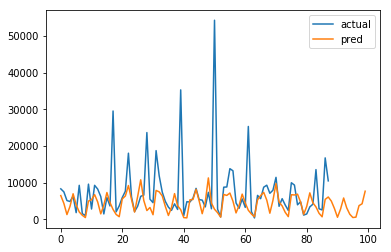

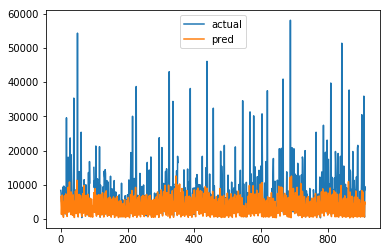

In [40]:
# Plot test results
n = 100
pred_sample = model.predict([seq_in[:n,:], cat_fea_in[:n,:]])[:,0]
plt.figure()
plt.plot(exp_test_output[:n,0])
plt.plot(pred_sample)
plt.legend(['actual', 'pred'])
plt.show()

n = 1000
pred_sample = model.predict([seq_in[:n,:], cat_fea_in[:n,:]])[:,0]
plt.figure()
plt.plot(exp_test_output[:n,0])
plt.plot(pred_sample)
plt.legend(['actual', 'pred'])
plt.show()

In [41]:
np.nanmean(np.abs(pred-exp_test_output)/exp_test_output)

0.52436745